<div class="usecase-title">Evaluating the Impact of Urban Heat Islands on Community Wellbeing in Melbourne</div>

<div class="usecase-authors"><b>Authored by: Sai Priyamvada</b> </div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python</div>
</div>

<header>
<h2>Scenario</h2>
<div> This use case explores the relationship between urban heat islands (UHIs) and community wellbeing in Melbourne. By analyzing temperature variations across different neighborhoods using microclimate sensor data, tree canopy coverage, and population density datasets, this  use case identifies areas most affected by UHIs. The findings will examine the correlation between higher temperatures and indicators such as physical health, mental health, and energy consumption. The use case also aims to recommend targeted interventions, such as increased tree planting or reflective surface materials, to mitigate UHI effects, promote urban cooling, and improve the quality of life for Melbourne residents. </div>

<div class="usecase-section-header"><b> Introduction or background relating to problem </b> </div>
1. As a city planner and public health researcher,I want to understand how Urban Heat Islands (UHIs) impact community wellbeing in Melbourne,So that I can identify high-risk areas and develop targeted interventions to reduce heat-related health risks, lower energy consumption, and improve residents’ quality of life.


<div class="usecase-section-header">What this use case will teach you</div>


At the end of this use case you will:
- Which areas in Melbourne are most affected by UHIs?
  How do temperature variations correlate with health indicators (e.g., hospital visits, heat-related illnesses)?
  What is the impact of UHIs on energy consumption and mental wellbeing?
  What urban planning interventions can reduce the effects of UHIs?

In [1]:
import requests
import pandas as pd
from io import StringIO
from tqdm import tqdm

def download_dataset(api_key, dataset_id, base_url='https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'):
    format = 'csv'
    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,
        'lang': 'en',
        'timezone': 'UTC',
        'api_key': api_key
    }
    
    with requests.get(url, params=params, stream=True) as response:
        if response.status_code == 200:
            total_size = int(response.headers.get('content-length', 0))
            chunk_size = 1024
            progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc=f"Downloading {dataset_id}")

            content = bytearray()
            for chunk in response.iter_content(chunk_size=chunk_size):
                if chunk:
                    content.extend(chunk)
                    progress_bar.update(len(chunk))

            progress_bar.close()
            return pd.read_csv(StringIO(content.decode('utf-8')), delimiter=';')
        else:
            print(f'Request failed with status code {response.status_code}')
            return None

# Dataset IDs
dataset_ids = {
    'microclimate': 'microclimate-sensors-data',
    'tree_canopies': 'tree-canopies-2021-urban-forest',
    'population_forecasts': 'city-of-melbourne-population-forecasts-by-small-area-2020-2040',
    'energy_consumption': 'block-level-energy-consumption-modelled-on-building-attributes-2021-projection-r',
    'boundaries': 'small-areas-for-census-of-land-use-and-employment-clue'
}

# Download all datasets
datasets = {key: download_dataset('', dataset_id) for key, dataset_id in dataset_ids.items()}

PART-1 DATA CLEANING AND PREPROCESSING

In [2]:
import pandas as pd
import geopandas as gpd  
import matplotlib.pyplot as plt
import seaborn as sns
import json

DATSET 1: MICROCLIMATE-SENSORS-DATA

In [3]:
microclimate_df = datasets['microclimate']
microclimate_df.drop_duplicates(inplace=True)
microclimate_df["sensorlocation"].fillna("Unknown", inplace=True)
microclimate_df.dropna(subset=["latlong"], inplace=True)
num_cols = ["minimumwinddirection", "averagewinddirection", "maximumwinddirection", 
            "minimumwindspeed", "averagewindspeed", "gustwindspeed", "airtemperature", 
            "relativehumidity", "atmosphericpressure", "pm25", "pm10", "noise"]
for col in num_cols:
    microclimate_df[col].fillna(microclimate_df[col].median(), inplace=True)
microclimate_df["received_at"] = pd.to_datetime(microclimate_df["received_at"])
microclimate_df[['latitude', 'longitude']] = microclimate_df['latlong'].str.split(',', expand=True).astype(float)

# Convert to GeoDataFrame
# microclimate_gdf = gpd.GeoDataFrame(microclimate_df, geometry=gpd.points_from_xy(microclimate_df.longitude, microclimate_df.latitude))
microclimate_gdf = gpd.GeoDataFrame(microclimate_df, geometry=gpd.points_from_xy(microclimate_df.longitude, microclimate_df.latitude), crs="EPSG:4326")

In [4]:
missing_values = microclimate_gdf.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 device_id               0
received_at             0
sensorlocation          0
latlong                 0
minimumwinddirection    0
averagewinddirection    0
maximumwinddirection    0
minimumwindspeed        0
averagewindspeed        0
gustwindspeed           0
airtemperature          0
relativehumidity        0
atmosphericpressure     0
pm25                    0
pm10                    0
noise                   0
latitude                0
longitude               0
geometry                0
dtype: int64


DATASET 2 : TREE CANOPIES 2021 URBAN FOREST
    

In [5]:
# ---  CLEAN TREE CANOPIES DATA ---
tree_canopies_df = datasets['tree_canopies']
tree_canopies_df.drop_duplicates(subset=['geo_point_2d'], inplace=True)
tree_canopies_df[['latitude', 'longitude']] = tree_canopies_df['geo_point_2d'].str.split(',', expand=True).astype(float)
tree_canopies_df['geo_shape_parsed'] = tree_canopies_df['geo_shape'].apply(json.loads)
tree_canopies_df['geo_shape_coordinates'] = tree_canopies_df['geo_shape_parsed'].apply(lambda x: x['coordinates'][0][0] if isinstance(x, dict) else None)

# Convert to GeoDataFrame
# tree_canopies_gdf = gpd.GeoDataFrame(tree_canopies_df, geometry=gpd.points_from_xy(tree_canopies_df.longitude, tree_canopies_df.latitude))
tree_canopies_gdf = gpd.GeoDataFrame(tree_canopies_df, geometry=gpd.points_from_xy(tree_canopies_df.longitude, tree_canopies_df.latitude), crs="EPSG:4326")

In [6]:
# Check for missing values
print(tree_canopies_gdf.isnull().sum())



geo_point_2d             0
geo_shape                0
latitude                 0
longitude                0
geo_shape_parsed         0
geo_shape_coordinates    0
geometry                 0
dtype: int64


DATASET 3: ENERGY CONSUMPTION

In [7]:
# --- STEP 3: CLEAN ENERGY CONSUMPTION DATA ---
energy_consumption_df = datasets['energy_consumption']
energy_consumption_df.drop_duplicates(subset=['geo_point_2d', 'total', 'geo_shape'], inplace=True)
energy_consumption_df[['latitude', 'longitude']] = energy_consumption_df['geo_point_2d'].str.split(',', expand=True).astype(float)
energy_consumption_df['geo_shape_parsed'] = energy_consumption_df['geo_shape'].apply(json.loads)

# Convert to GeoDataFrame and set CRS
energy_consumption_gdf = gpd.GeoDataFrame(energy_consumption_df, geometry=gpd.points_from_xy(energy_consumption_df.longitude, energy_consumption_df.latitude), crs="EPSG:4326")

In [8]:
print(energy_consumption_gdf.isnull().sum())


geo_point_2d        0
geo_shape           0
total               0
latitude            0
longitude           0
geo_shape_parsed    0
geometry            0
dtype: int64


DATASET4: POPULATION FORECASTS

In [9]:
population_forecasts_df = datasets['population_forecasts']
print(population_forecasts_df.isnull().sum())
print(population_forecasts_df.columns)

In [ ]:
DATSET 5: Small Areas for Census of Land Use and Employment

In [12]:
boundaries_df = datasets['boundaries']
print(boundaries_df.info())
print(boundaries_df.head(4))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   geo_point_2d  13 non-null     object 
 1   geo_shape     13 non-null     object 
 2   featurenam    13 non-null     object 
 3   shape_area    13 non-null     float64
 4   shape_len     13 non-null     float64
dtypes: float64(2), object(3)
memory usage: 648.0+ bytes
None
                             geo_point_2d  \
0   -37.78711656492933, 144.9515603312268   
1  -37.82529018627908, 144.96176162794978   
2  -37.83760704949379, 144.98292521995853   
3  -37.814581164837946, 144.9825008488323   

                                           geo_shape      featurenam  \
0  {"coordinates": [[[[144.94036533536232, -37.78...       Parkville   
1  {"coordinates": [[[[144.95599687351128, -37.82...       Southbank   
2  {"coordinates": [[[[144.98502208625717, -37.84...     South Yarra   
3  {"coordinates": [[

In [13]:
# Extract latitude and longitude from 'geo_point_2d'
boundaries_df[['latitude', 'longitude']] = boundaries_df['geo_point_2d'].str.split(',', expand=True)

# Convert latitude and longitude columns to float for numerical operations
boundaries_df['latitude'] = boundaries_df['latitude'].astype(float)
boundaries_df['longitude'] = boundaries_df['longitude'].astype(float)

# Check the updated DataFrame
print(boundaries_df[['latitude', 'longitude']].head())


    latitude   longitude
0 -37.787117  144.951560
1 -37.825290  144.961762
2 -37.837607  144.982925
3 -37.814581  144.982501
4 -37.798449  144.945063


In [14]:
import geopandas as gpd
from shapely.geometry import shape
import ast

# Convert geo_shape to geometries
boundaries_df['geometry'] = boundaries_df['geo_shape'].apply(lambda x: shape(ast.literal_eval(x)))

# Create GeoDataFrame from the DataFrame
gdf_boundaries = gpd.GeoDataFrame(boundaries_df, geometry='geometry')

# Set the CRS (Coordinate Reference System) if known, or assume it's in a common CRS like WGS 84 (EPSG:4326)
gdf_boundaries.set_crs(epsg=4326, inplace=True)

# Check the resulting GeoDataFrame
print(gdf_boundaries.info())
print(gdf_boundaries.head())


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   geo_point_2d  13 non-null     object  
 1   geo_shape     13 non-null     object  
 2   featurenam    13 non-null     object  
 3   shape_area    13 non-null     float64 
 4   shape_len     13 non-null     float64 
 5   latitude      13 non-null     float64 
 6   longitude     13 non-null     float64 
 7   geometry      13 non-null     geometry
dtypes: float64(4), geometry(1), object(3)
memory usage: 960.0+ bytes
None
                             geo_point_2d  \
0   -37.78711656492933, 144.9515603312268   
1  -37.82529018627908, 144.96176162794978   
2  -37.83760704949379, 144.98292521995853   
3  -37.814581164837946, 144.9825008488323   
4  -37.79844895689088, 144.94506274103145   

                                           geo_shape       featurenam  \
0  {"coordinates": [[[[144.9403

In [ ]:
PART -2 VISUALIZATION OF DATASETS

0    MULTIPOLYGON (((144.94037 -37.78762, 144.94007...
1    MULTIPOLYGON (((144.95600 -37.82310, 144.95808...
2    MULTIPOLYGON (((144.98502 -37.84568, 144.98399...
3    MULTIPOLYGON (((144.97322 -37.80776, 144.97319...
4    MULTIPOLYGON (((144.95732 -37.80155, 144.95745...
Name: geometry, dtype: geometry


<Axes: >

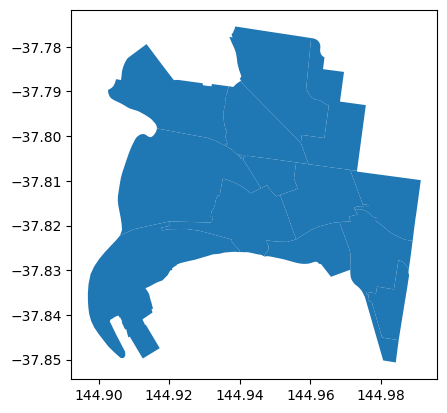

In [15]:
# Ensure the geometry is properly assigned
print(gdf_boundaries.geometry.head())

# Plot the geometries
gdf_boundaries.plot()


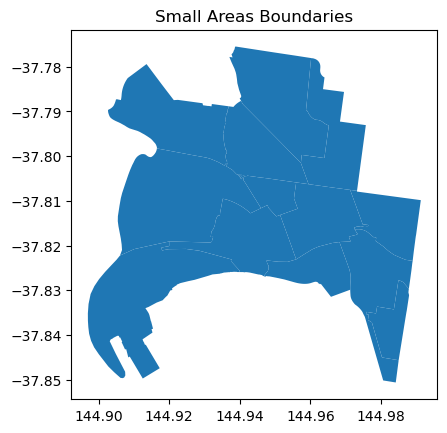

In [16]:
import matplotlib.pyplot as plt

# Plot the GeoDataFrame to visualize the boundaries
gdf_boundaries.plot()
plt.title("Small Areas Boundaries")
plt.show()


In [17]:
# Rename columns to ensure no column name exceeds 10 characters
gdf_boundaries.rename(columns={
    'geo_point_2d': 'geo_point',
    'geo_shape': 'geo_shape',
    'featurenam': 'feature',
    'shape_area': 'area',
    'shape_len': 'length'
}, inplace=True)

# Save as Shapefile
gdf_boundaries.to_file('boundaries.shp')


- Visualize Temperature Variations You can start by plotting the temperature values from your sensors on a map to see if there are regions where higher temperatures are concentrated.

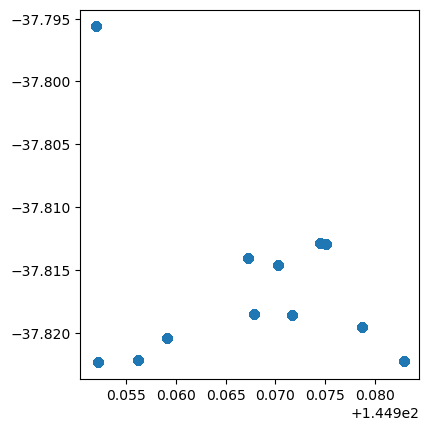

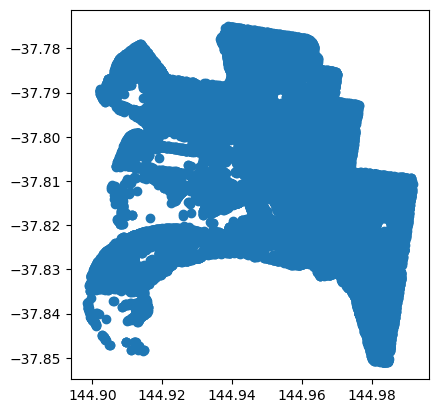

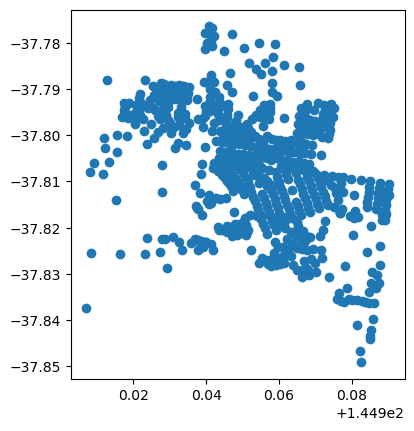

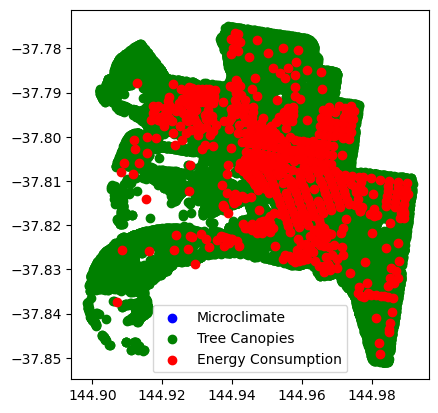

In [52]:
microclimate_gdf.plot()
tree_canopies_gdf.plot()
energy_consumption_gdf.plot()
ax = microclimate_gdf.plot(color='blue', label='Microclimate')
tree_canopies_gdf.plot(ax=ax, color='green', label='Tree Canopies')
energy_consumption_gdf.plot(ax=ax, color='red', label='Energy Consumption')
ax.legend()


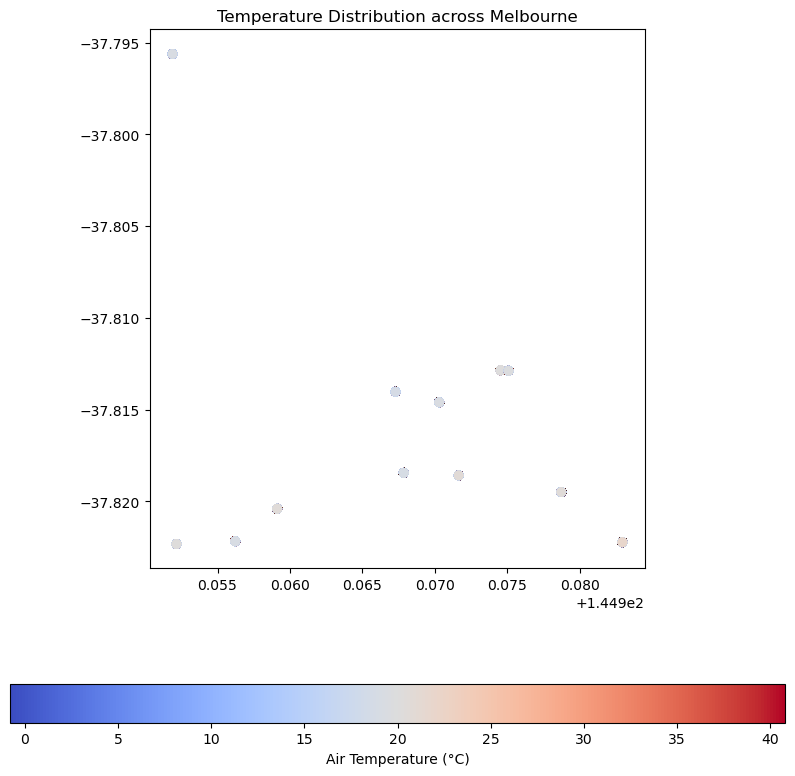

In [46]:
import matplotlib.pyplot as plt

# Plot microclimate data with color coding based on temperature
fig, ax = plt.subplots(figsize=(10, 10))
microclimate_gdf.plot(ax=ax, column='airtemperature', cmap='coolwarm', legend=True,
                      legend_kwds={'label': "Air Temperature (°C)", 'orientation': "horizontal"})
ax.set_title('Temperature Distribution across Melbourne')
plt.show()


- Calculate Temperature Difference You can calculate the difference in temperature between the urban area (high sensor concentration) and surrounding areas (lower sensor density or rural areas). If you don’t have a predefined boundary for urban and rural areas, you can define a threshold of temperature difference for identifying UHI areas.



In [47]:
urban_threshold = 25  # Set a temperature threshold for urban areas (e.g., above 25°C)

uhi_affected_areas = microclimate_gdf[microclimate_gdf['airtemperature'] > urban_threshold]
print(f"Number of UHI-Affected Areas: {len(uhi_affected_areas)}")


Number of UHI-Affected Areas: 29327


- Buffer Analysis You can perform a buffer analysis around the UHI-affected areas to assess the impact radius (e.g., a 500m or 1km radius around the hot spots) and see if there are larger regions of high temperatures in these zones.

/var/folders/vr/8j98cl8s6_z2ws2k2r0s78ym0000gn/T/ipykernel_5842/2362502574.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  uhi_affected_buffer['geometry'] = uhi_affected_buffer.geometry.buffer(0.01)  # 0.01 degrees ~ 1km


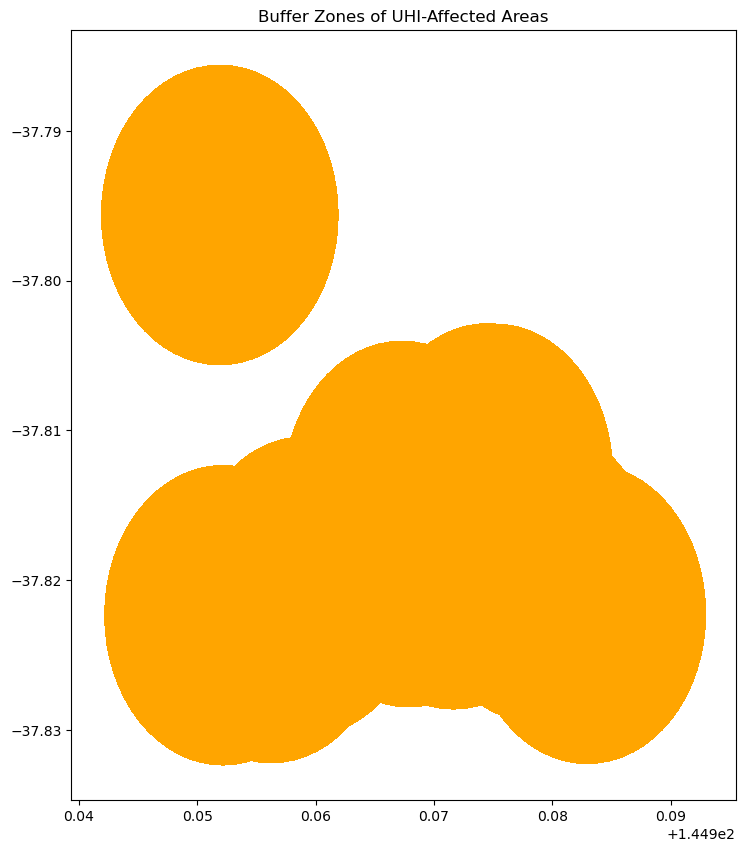

In [48]:
uhi_affected_buffer = uhi_affected_areas.copy()
uhi_affected_buffer['geometry'] = uhi_affected_buffer.geometry.buffer(0.01)  # 0.01 degrees ~ 1km
uhi_affected_buffer.plot(figsize=(10, 10), color='orange', alpha=0.5)
plt.title('Buffer Zones of UHI-Affected Areas')
plt.show()


DATA INTEGRATION PART:


Reprojected All GeoDataFrames:

- Ensured that all datasets are in the same projected CRS (EPSG:28355) for accurate spatial analysis.

- Performed Spatial Joins:

- Microclimate & Tree Canopies: Found the nearest tree canopy to each microclimate sensor and identified sensors within 10 meters of a tree canopy.

- Microclimate & Energy Consumption: Identified sensors within energy consumption zones (if polygon-based) and found the nearest energy consumption points.

- Tree Canopies & Energy Consumption: Found tree canopies within energy consumption zones or the nearest energy point to each tree canopy.

- Linked Environmental Data to Geographic Boundaries:

- Assigned feature boundaries to microclimate, tree canopy, and energy consumption datasets using a spatial join.

- Merged with Population Forecast Data:

- Connected the environmental data (microclimate, tree canopy, energy consumption) to population forecasts using geography and feature.

In [19]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point


# - microclimate_gdf (with Point geometries)
# - tree_canopies_gdf (likely with Point geometries)
# - energy_consumption_gdf (could be Points or Polygons)

# --- Check Coordinate Reference Systems (CRS) ---

print("Microclimate CRS:", microclimate_gdf.crs)
print("Tree Canopies CRS:", tree_canopies_gdf.crs)
print("Energy Consumption CRS:", energy_consumption_gdf.crs)

# Define a preferred projected CRS for Melbourne (VICGRID94 Zone 55)
projected_crs = "EPSG:28355"

# Reproject to the projected CRS for more accurate distance-based calculations
if microclimate_gdf.crs != projected_crs:
    microclimate_gdf_proj = microclimate_gdf.to_crs(projected_crs)
    print(f"\nMicroclimate GeoDataFrame reprojected to {projected_crs}")
else:
    microclimate_gdf_proj = microclimate_gdf.copy()

if tree_canopies_gdf.crs != projected_crs:
    tree_canopies_gdf_proj = tree_canopies_gdf.to_crs(projected_crs)
    print(f"Tree Canopies GeoDataFrame reprojected to {projected_crs}")
else:
    tree_canopies_gdf_proj = tree_canopies_gdf.copy()

if energy_consumption_gdf.crs != projected_crs:
    energy_consumption_gdf_proj = energy_consumption_gdf.to_crs(projected_crs)
    print(f"Energy Consumption GeoDataFrame reprojected to {projected_crs}")
else:
    energy_consumption_gdf_proj = energy_consumption_gdf.copy()

print("\n--- Performing Spatial Joins ---")

# 1. Microclimate and Tree Canopies

print("\n--- Microclimate and Tree Canopies ---")

# Since tree canopies are likely points, we can find the nearest tree to each sensor
nearest_tree = gpd.sjoin_nearest(microclimate_gdf_proj, tree_canopies_gdf_proj[['geometry']], how='left', lsuffix='micro', rsuffix='tree', max_distance=100)
print(f"Nearest tree canopy to each microclimate sensor (first 5 rows):")
print(nearest_tree.head())


# This requires buffering the tree points to create a polygon around them
tree_canopies_buffered = tree_canopies_gdf_proj.copy()
tree_canopies_buffered['geometry'] = tree_canopies_buffered.geometry.buffer(10) # Buffer by 10 meters 

microclimate_within_buffered_trees = gpd.sjoin(microclimate_gdf_proj, tree_canopies_buffered[['geometry']], how='inner', predicate='within', lsuffix='micro', rsuffix='tree_buffered')
print(f"\nMicroclimate sensors within a 10-meter buffer of a tree canopy: {len(microclimate_within_buffered_trees)}")
if not microclimate_within_buffered_trees.empty:
    print("First 5 rows of microclimate sensors within buffered tree canopies:")
    print(microclimate_within_buffered_trees.head())

# 2. Microclimate and Energy Consumption

print("\n--- Microclimate and Energy Consumption ---")

# Find microclimate sensors located within energy consumption zones (if energy_consumption_gdf has polygons)
if 'geometry' in energy_consumption_gdf_proj.columns and energy_consumption_gdf_proj.geom_type.iloc[0].startswith('Polygon'):
    microclimate_in_energy = gpd.sjoin(microclimate_gdf_proj, energy_consumption_gdf_proj[['geometry', 'total']], how='inner', predicate='within', lsuffix='micro', rsuffix='energy')
    print(f"Number of microclimate sensors within energy consumption zones: {len(microclimate_in_energy)}")
    if not microclimate_in_energy.empty:
        print("First 5 rows of microclimate sensors within energy consumption zones:")
        print(microclimate_in_energy.head())
else:
    print("Energy Consumption GeoDataFrame does not appear to have polygon geometries for 'within' predicate (or no 'geometry' column).")

# Find the nearest energy consumption point/area to each microclimate sensor
nearest_energy = gpd.sjoin_nearest(microclimate_gdf_proj, energy_consumption_gdf_proj[['geometry', 'total']], how='left', lsuffix='micro', rsuffix='energy', max_distance=50)
print(f"\nNearest energy consumption to each microclimate sensor (first 5 rows):")
print(nearest_energy.head())

# 3. Tree Canopies and Energy Consumption 

print("\n--- Tree Canopies and Energy Consumption ---")

# Find tree canopies located within energy consumption zones
if 'geometry' in energy_consumption_gdf_proj.columns and energy_consumption_gdf_proj.geom_type.iloc[0].startswith('Polygon') and \
   'geometry' in tree_canopies_gdf_proj.columns and tree_canopies_gdf_proj.geom_type.iloc[0].startswith('Point'):
    tree_canopies_in_energy = gpd.sjoin(tree_canopies_gdf_proj, energy_consumption_gdf_proj[['geometry', 'total']], how='inner', predicate='within', lsuffix='tree', rsuffix='energy')
    print(f"Number of tree canopies within energy consumption zones: {len(tree_canopies_in_energy)}")
    if not tree_canopies_in_energy.empty:
        print("First 5 rows of tree canopies within energy consumption zones:")
        print(tree_canopies_in_energy.head())
elif 'geometry' in energy_consumption_gdf_proj.columns and energy_consumption_gdf_proj.geom_type.iloc[0].startswith('Point') and \
     'geometry' in tree_canopies_gdf_proj.columns and tree_canopies_gdf_proj.geom_type.iloc[0].startswith('Point'):
    nearest_energy_to_trees = gpd.sjoin_nearest(tree_canopies_gdf_proj, energy_consumption_gdf_proj[['geometry', 'total']], how='left', lsuffix='tree', rsuffix='energy', max_distance=50)
    print(f"\nNearest energy consumption point to each tree canopy (first 5 rows):")
    print(nearest_energy_to_trees.head())
else:
    print("Cannot perform 'within' join as expected geometries (Polygon for energy consumption) are not present, or performing nearest join between points.")

Microclimate CRS: EPSG:4326
Tree Canopies CRS: EPSG:4326
Energy Consumption CRS: EPSG:4326

Microclimate GeoDataFrame reprojected to EPSG:28355
Tree Canopies GeoDataFrame reprojected to EPSG:28355
Energy Consumption GeoDataFrame reprojected to EPSG:28355

--- Performing Spatial Joins ---

--- Microclimate and Tree Canopies ---
Nearest tree canopy to each microclimate sensor (first 5 rows):
            device_id               received_at  \
0  ICTMicroclimate-08 2025-02-09 00:54:37+00:00   
1  ICTMicroclimate-11 2025-02-09 01:02:11+00:00   
2  ICTMicroclimate-05 2025-02-09 01:03:24+00:00   
3  ICTMicroclimate-01 2025-02-09 01:02:43+00:00   
4  ICTMicroclimate-09 2025-02-09 01:17:37+00:00   

                                      sensorlocation  \
0  Swanston St - Tram Stop 13 adjacent Federation...   
1                                   1 Treasury Place   
2                 Enterprize Park - Pole ID: COM1667   
3                    Birrarung Marr Park - Pole 1131   
4  SkyFarm (Jeff's S

In [20]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Step 1: Convert population data into a GeoDataFrame
# Split 'geo_point_2d' into latitude and longitude
boundaries_df[['lat', 'lon']] = boundaries_df['geo_point_2d'].str.split(',', expand=True)
boundaries_df['lat'] = boundaries_df['lat'].astype(float)
boundaries_df['lon'] = boundaries_df['lon'].astype(float)

# Create a GeoDataFrame from population data
geometry = [Point(lon, lat) for lon, lat in zip(boundaries_df['lon'], boundaries_df['lat'])]
population_gdf = gpd.GeoDataFrame(boundaries_df, geometry=geometry)

# Step 2: Ensure both GeoDataFrames have the same CRS
# For example, let's assume both datasets should be in EPSG:4326 (WGS 84)
population_gdf.set_crs('EPSG:4326', allow_override=True, inplace=True)
gdf_boundaries.set_crs('EPSG:4326', allow_override=True, inplace=True)

# Step 3: Perform a spatial join to merge the population data with the boundaries
# We will join based on whether the population point is within the boundary polygon
joined_gdf = gpd.sjoin(population_gdf, gdf_boundaries, how='inner', op='within')

# Step 4: Check the result
print(joined_gdf.head())


                             geo_point_2d  \
0   -37.78711656492933, 144.9515603312268   
1  -37.82529018627908, 144.96176162794978   
2  -37.83760704949379, 144.98292521995853   
3  -37.814581164837946, 144.9825008488323   
4  -37.79844895689088, 144.94506274103145   

                                      geo_shape_left       featurenam  \
0  {"coordinates": [[[[144.94036533536232, -37.78...        Parkville   
1  {"coordinates": [[[[144.95599687351128, -37.82...        Southbank   
2  {"coordinates": [[[[144.98502208625717, -37.84...      South Yarra   
3  {"coordinates": [[[[144.9732217743585, -37.807...   East Melbourne   
4  {"coordinates": [[[[144.95732229939304, -37.80...  North Melbourne   

     shape_area    shape_len  latitude_left  longitude_left  \
0  4.050997e+06  9224.569397     -37.787117      144.951560   
1  1.596010e+06  6012.377239     -37.825290      144.961762   
2  1.057773e+06  5424.136446     -37.837607      144.982925   
3  1.909073e+06  6557.914249     -37.8

/opt/miniconda3/envs/MelbourneCityOpenData/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [21]:
# Drop columns that are now redundant after the join
# For example, 'geo_point_2d' and 'geometry' were already in the joined data.
joined_gdf = joined_gdf.drop(columns=['geo_point_2d', 'geo_shape_left', 'latitude_left', 'longitude_left'])

# Rename columns for clarity
joined_gdf.rename(columns={
    'geometry': 'population_geometry',  # Renaming the geometry column
    'featurenam': 'boundary_name',  # Renaming to make it clearer
    'shape_area': 'boundary_area',  # Renaming boundary area
    'shape_len': 'boundary_length',  # Renaming boundary length
    'lat': 'population_lat',  # Renaming population latitude
    'lon': 'population_lon',  # Renaming population longitude
    'index_right': 'boundary_index',  # Renaming to make it clearer
    'geo_shape_right': 'boundary_geo_shape',  # Renaming to make it clearer
    'feature': 'boundary_feature',  # Renaming to make it clearer
    'area': 'boundary_area2',  # Renaming for better clarity
    'length': 'boundary_length2',  # Renaming for better clarity
    'latitude_right': 'boundary_lat',  # Renaming boundary lat
    'longitude_right': 'boundary_lon'  # Renaming boundary lon
}, inplace=True)

# You can also keep the rows that are spatially matched and drop duplicates if needed
joined_gdf = joined_gdf.drop_duplicates(subset=['population_geometry'])

print(joined_gdf.head())


     boundary_name  boundary_area  boundary_length  \
0        Parkville   4.050997e+06      9224.569397   
1        Southbank   1.596010e+06      6012.377239   
2      South Yarra   1.057773e+06      5424.136446   
3   East Melbourne   1.909073e+06      6557.914249   
4  North Melbourne   2.408377e+06      7546.649191   

           population_geometry  population_lat  population_lon  \
0  POINT (144.95156 -37.78712)      -37.787117      144.951560   
1  POINT (144.96176 -37.82529)      -37.825290      144.961762   
2  POINT (144.98293 -37.83761)      -37.837607      144.982925   
3  POINT (144.98250 -37.81458)      -37.814581      144.982501   
4  POINT (144.94506 -37.79845)      -37.798449      144.945063   

   boundary_index                               geo_point  \
0               0   -37.78711656492933, 144.9515603312268   
1               1  -37.82529018627908, 144.96176162794978   
2               2  -37.83760704949379, 144.98292521995853   
3               3  -37.81458116483

In [25]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt


projected_crs = "EPSG:28355"

# Reproject all GeoDataFrames to the projected CRS
if microclimate_gdf.crs != projected_crs:
    microclimate_gdf_proj = microclimate_gdf.to_crs(projected_crs)
else:
    microclimate_gdf_proj = microclimate_gdf.copy()

if tree_canopies_gdf.crs != projected_crs:
    tree_canopies_gdf_proj = tree_canopies_gdf.to_crs(projected_crs)
else:
    tree_canopies_gdf_proj = tree_canopies_gdf.copy()

if energy_consumption_gdf.crs != projected_crs:
    energy_consumption_gdf_proj = energy_consumption_gdf.to_crs(projected_crs)
else:
    energy_consumption_gdf_proj = energy_consumption_gdf.copy()

if gdf_boundaries.crs != projected_crs:
    gdf_boundaries_proj = gdf_boundaries.to_crs(projected_crs)
else:
    gdf_boundaries_proj = gdf_boundaries.copy()

# --- Spatial Join Environmental Data with Boundaries ---

print("\n--- Spatial Join with Boundaries ---")

# Microclimate
microclimate_with_boundaries = gpd.sjoin(microclimate_gdf_proj, gdf_boundaries_proj[['geometry', 'feature']], how='left', predicate='within')
print("\nMicroclimate data with boundaries (first 5 rows):\n", microclimate_with_boundaries.head())

# Tree Canopies
tree_canopies_with_boundaries = gpd.sjoin(tree_canopies_gdf_proj, gdf_boundaries_proj[['geometry', 'feature']], how='left', predicate='within')
print("\nTree canopy data with boundaries (first 5 rows):\n", tree_canopies_with_boundaries.head())

# Energy Consumption
energy_consumption_with_boundaries = gpd.sjoin(energy_consumption_gdf_proj, gdf_boundaries_proj[['geometry', 'feature']], how='left', predicate='within')
print("\nEnergy consumption data with boundaries (first 5 rows):\n", energy_consumption_with_boundaries.head())

# --- Merge with Population Forecasts ---

print("\n--- Merge with Population Forecasts ---")



--- Spatial Join with Boundaries ---

Microclimate data with boundaries (first 5 rows):
             device_id               received_at  \
0  ICTMicroclimate-08 2025-02-09 00:54:37+00:00   
1  ICTMicroclimate-11 2025-02-09 01:02:11+00:00   
2  ICTMicroclimate-05 2025-02-09 01:03:24+00:00   
3  ICTMicroclimate-01 2025-02-09 01:02:43+00:00   
4  ICTMicroclimate-09 2025-02-09 01:17:37+00:00   

                                      sensorlocation  \
0  Swanston St - Tram Stop 13 adjacent Federation...   
1                                   1 Treasury Place   
2                 Enterprize Park - Pole ID: COM1667   
3                    Birrarung Marr Park - Pole 1131   
4  SkyFarm (Jeff's Shed). Rooftop - Melbourne Con...   

                    latlong  minimumwinddirection  averagewinddirection  \
0  -37.8184515, 144.9678474                   0.0                 153.0   
1   -37.812888, 144.9750857                   0.0                 144.0   
2  -37.8204083, 144.9591192              

In [28]:
# Convert 'feature' to string to ensure compatibility
microclimate_with_boundaries['feature'] = microclimate_with_boundaries['feature'].astype(str)
tree_canopies_with_boundaries['feature'] = tree_canopies_with_boundaries['feature'].astype(str)
energy_consumption_with_boundaries['feature'] = energy_consumption_with_boundaries['feature'].astype(str)

# Keep only necessary columns to reduce memory usage
population_forecasts_df = population_forecasts_df[['geography', 'value']]
microclimate_with_boundaries = microclimate_with_boundaries[['feature']]
tree_canopies_with_boundaries = tree_canopies_with_boundaries[['feature']]
energy_consumption_with_boundaries = energy_consumption_with_boundaries[['feature']]


In [29]:
chunk_size = 10000  
merged_chunks = []

for start in range(0, len(population_forecasts_df), chunk_size):
    chunk = population_forecasts_df.iloc[start:start + chunk_size]
    merged_chunk = pd.merge(chunk, microclimate_with_boundaries, left_on='geography', right_on='feature', how='inner')
    merged_chunks.append(merged_chunk)

merged_pop_micro = pd.concat(merged_chunks, ignore_index=True)
print(merged_pop_micro.head())


   geography  value    feature
0  Docklands    868  Docklands
1  Docklands    868  Docklands
2  Docklands    868  Docklands
3  Docklands    868  Docklands
4  Docklands    868  Docklands


In [30]:
merged_pop_micro = pd.merge(population_forecasts_df, microclimate_with_boundaries, left_on='geography', right_on='feature', how='inner')
print("Microclimate Merge Successful!", merged_pop_micro.shape)

Microclimate Merge Successful! (213029460, 3)


In [31]:
merged_pop_trees = pd.merge(population_forecasts_df, tree_canopies_with_boundaries, left_on='geography', right_on='feature', how='inner')
print("Tree Canopies Merge Successful!", merged_pop_trees.shape)

Tree Canopies Merge Successful! (41059116, 3)


In [32]:
# Test Energy Consumption Merge
merged_pop_energy = pd.merge(population_forecasts_df, energy_consumption_with_boundaries, left_on='geography', right_on='feature', how='inner')
print("Energy Consumption Merge Successful!", merged_pop_energy.shape)

Energy Consumption Merge Successful! (483084, 3)


In [35]:
# Merge population forecasts based on matching boundaries
merged_df = microclimate_with_boundaries.merge(
    population_forecasts_df, left_on="feature", right_on="geography", how="left"
)

print(merged_df.head())


           feature        geography  value
0  Melbourne (CBD)  Melbourne (CBD)    146
1  Melbourne (CBD)  Melbourne (CBD)    849
2  Melbourne (CBD)  Melbourne (CBD)    244
3  Melbourne (CBD)  Melbourne (CBD)    155
4  Melbourne (CBD)  Melbourne (CBD)   4246
